# Homework03:  Topic Modeling with Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a method for finding latent similarities between documents treated as a bag of words by using a low rank approximation. It is used for document classification, clustering and retrieval. For example, LSA can be used to search for prior art given a new patent application. In this homework, we will implement a small library for simple latent semantic analysis as a practical example of the application of SVD. The ideas are very similar to PCA. SVD is also used in recommender systems in an similar fashion (for an SVD-based recommender system library, see [Surpise](http://surpriselib.com). 

We will implement a toy example of LSA to get familiar with the ideas. If you want to use LSA or similar methods for statistical language analysis, the most efficient Python libraries are probably [gensim](https://radimrehurek.com/gensim/) and [spaCy](https://spacy.io) - these also provide an online algorithm - i.e. the training information can be continuously updated. Other useful functions for processing natural language can be found in the [Natural Language Toolkit](http://www.nltk.org/).

**Note**: The SVD from scipy.linalg performs a full decomposition, which is inefficient since we only need to decompose until we get the first k singluar values. If the SVD from `scipy.linalg` is too slow, please use the `sparsesvd` function from the [sparsesvd](https://pypi.python.org/pypi/sparsesvd/) package to perform SVD instead.  You can install in the usual way with 
```
!pip install sparsesvd
```

Then import the following
```python
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix 
```

and use as follows
```python
sparsesvd(csc_matrix(M), k=10)
```

**Exercise 1 (20 points)**.  Calculating pairwise distance matrices.

Suppose we want to construct a distance matrix between the rows of a matrix. For example, given the matrix 

```python
M = np.array([[1,2,3],[4,5,6]])
```

the distance matrix using Euclidean distance as the measure would be
```python
[[ 0.000  1.414  2.828]
 [ 1.414  0.000  1.414]
 [ 2.828  1.414  0.000]] 
```
if $M$ was a collection of column vectors.

Write a function to calculate the pairwise-distance matrix given the matrix $M$ and some arbitrary distance function. Your functions should have the following signature:
```
def func_name(M, distance_func):
    pass
```

0. Write a distance function for the Euclidean, squared Euclidean and cosine measures.
1. Write the function using looping for M as a collection of row vectors.
2. Write the function using looping for M as a collection of column vectors.
3. Wrtie the function using broadcasting for M as a collection of row vectors.
4. Write the function using broadcasting for M as a collection of column vectors. 

For 3 and 4, try to avoid using transposition (but if you get stuck, there will be no penalty for using transposition). Check that all four functions give the same result when applied to the given matrix $M$.

In [1]:
import numpy as np
import scipy.linalg as la
import string
import pandas as pd
from scipy import stats

In [6]:
np.set_printoptions(precision=4)

In [9]:
def Euc(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def sqEuc(x, y):
    return np.sum((x - y) ** 2)

def Cos(x, y):
    return np.dot(x.T, y)/(np.linalg.norm(x) * np.linalg.norm(y))

In [3]:
M = np.array([[1,2,3],[4,5,6]])

In [14]:
def loop_row(M, distance_func):
    
    n = M.shape[0]
    dist = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist[i, j] = dist[j, i] = distance_func(M[i, :], M[j, :])
            
    return dist

def loop_col(M, distance_func):
    return loop_row(M.T, distance_func)

def broadcast_row(M, distance_func):
    dist = np.sum(M ** 2, axis = 1) + np.sum(M ** 2, axis = 1)[:, np.newaxis] - 2 * np.dot(M, M.T)
    return dist

broadcast_row(M, Euc)

array([[ 0, 27],
       [27,  0]])

**Exercise 2 (20 points)**. 

**Exercise 2 (20 points)**. Write 3 functions to calculate the term frequency (tf), the inverse document frequency (idf) and the product (tf-idf). Each function should take a single argument `docs`, which is a dictionary of (key=identifier, value=document text) pairs, and return an appropriately sized array. Convert '-' to ' ' (space), remove punctuation, convert text to lowercase and split on whitespace to generate a collection of terms from the document text.

- tf = the number of occurrences of term $i$ in document $j$
- idf = $\log \frac{n}{1 + \text{df}_i}$ where $n$ is the total number of documents and $\text{df}_i$ is the number of documents in which term $i$ occurs.

Print the table of tf-idf values for the following document collection

```
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}
```

In [25]:
def tf(docs):
    doc_words = [doc.strip().lower().translate(str.maketrans('-', ' ', string.punctuation)).split() 
                 for key, doc in docs.items()]
    words = [word for words in doc_words for word in words]
    terms = set(words)
    
    table = np.zeros((len(terms), len(docs)), dtype = 'int')
    for i, term in enumerate(terms):
        for j, doc in enumerate(doc_words):
            table[i, j] = doc.count(term)
            
    df = pd.DataFrame(table, columns = docs.keys(), index=terms)
    
    return df

def idf(docs):
    doc_words = [doc.strip().lower().translate(str.maketrans('-', ' ', string.punctuation)).split() 
                 for key, doc in docs.items()]
    words = [word for words in doc_words for word in words]
    terms = set(words)
    
    table = np.zeros((len(terms)), dtype = 'int')
    for i, term in enumerate(terms):
        for doc in doc_words:
            table[i] += int(term in doc)
    
    table = np.log(len(docs) / (1 + table))
    
    df = pd.DataFrame(table, columns=['idf'], index = terms)
    
    return df

def tfidf(docs):
    tf_tbl = tf(docs)
    idf_tbl = idf(docs)
    
    tfidf_tbl = pd.DataFrame(np.array(tf_tbl) * np.array(idf_tbl),columns = docs.keys(), index = idf_tbl.index)
    return tfidf_tbl
    

In [26]:
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}

print(tf(docs))
print(idf(docs))
print(tfidf(docs))


          s1  s2  s3  s4
lion       0   0   0   1
the        1   1   3   5
dog        0   0   1   1
elephant   0   0   1   1
tiger      0   0   0   1
lazy       0   0   1   0
peacock    0   0   0   1
over       0   1   0   0
quick      1   0   0   0
brown      1   1   0   0
fox        1   1   0   0
jumps      0   4   0   0
               idf
lion      0.693147
the      -0.223144
dog       0.287682
elephant  0.287682
tiger     0.693147
lazy      0.693147
peacock   0.693147
over      0.693147
quick     0.693147
brown     0.287682
fox       0.287682
jumps     0.693147
                s1        s2        s3        s4
lion      0.000000  0.000000  0.000000  0.693147
the      -0.223144 -0.223144 -0.669431 -1.115718
dog       0.000000  0.000000  0.287682  0.287682
elephant  0.000000  0.000000  0.287682  0.287682
tiger     0.000000  0.000000  0.000000  0.693147
lazy      0.000000  0.000000  0.693147  0.000000
peacock   0.000000  0.000000  0.000000  0.693147
over      0.000000  0.693147  0.0000

**Exercise 3 (20 points)**. 

1. Write a function that takes a matrix $M$ and an integer $k$ as arguments, and reconstructs a reduced matrix using only the $k$ largest singular values. Use the `scipy.linagl.svd` function to perform the decomposition. This is the least squares approximation to the matrix $M$ in $k$ dimensions.

2. Apply the function you just wrote to the following term-frequency matrix for a set of $9$ documents using $k=2$ and print the reconstructed matrix $M'$.
```
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])
```

3. Calculate the pairwise correlation matrix for the original matrix M and the reconstructed matrix using $k=2$ singular values (you may use [scipy.stats.spearmanr](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) to do the calculations). Consider the fist 5 sets of documents as one group $G1$ and the last 4 as another group $G2$ (i.e. first 5 and last 4 columns). What is the average within group correlation for $G1$, $G2$ and the average cross-group correlation for G1-G2 using either $M$ or $M'$. (Do not include self-correlation in the within-group calculations.).

In [2]:
def reconstruct(M, k):
    U, s, Vt = la.svd(M, full_matrices = False)
    M_reduced = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]
    
    return M_reduced

In [9]:
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 2, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 1]])

k = 2

Mp = reconstruct(M, k)
Mp

array([[ 0.1621,  0.4005,  0.379 ,  0.4676,  0.176 , -0.0527, -0.1151,
        -0.1591, -0.0918],
       [ 0.1406,  0.3698,  0.329 ,  0.4004,  0.165 , -0.0328, -0.0706,
        -0.0968, -0.043 ],
       [ 0.1524,  0.505 ,  0.3579,  0.4101,  0.2362,  0.0242,  0.0598,
         0.0869,  0.124 ],
       [ 0.258 ,  0.8411,  0.6057,  0.6974,  0.3923,  0.0331,  0.0832,
         0.1218,  0.1874],
       [ 0.4488,  1.2344,  1.0509,  1.2658,  0.5563, -0.0738, -0.1547,
        -0.2096, -0.0489],
       [ 0.1596,  0.5817,  0.3752,  0.4169,  0.2765,  0.0559,  0.1322,
         0.1889,  0.2169],
       [ 0.1596,  0.5817,  0.3752,  0.4169,  0.2765,  0.0559,  0.1322,
         0.1889,  0.2169],
       [ 0.2185,  0.5496,  0.511 ,  0.6281,  0.2425, -0.0654, -0.1425,
        -0.1966, -0.1079],
       [ 0.0969,  0.5321,  0.2299,  0.2118,  0.2665,  0.1368,  0.3146,
         0.4444,  0.425 ],
       [-0.0613,  0.2321, -0.1389, -0.2656,  0.1449,  0.2404,  0.5461,
         0.7674,  0.6637],
       [-0.0647,  0.

In [18]:
M_cor = stats.spearmanr(M).correlation
Mp_cor = stats.spearmanr(Mp).correlation
print(M_cor)
print(Mp_cor)

[[ 1.     -0.1925  0.      0.0734 -0.3333 -0.1741 -0.2582 -0.3333 -0.3333]
 [-0.1925  1.      0.     -0.1271  0.5774 -0.3015 -0.4472 -0.5774 -0.1925]
 [ 0.      0.      1.      0.4382  0.     -0.2132 -0.3162 -0.4082 -0.4082]
 [ 0.0734 -0.1271  0.4382  1.     -0.3303 -0.1725 -0.2558 -0.3303 -0.3303]
 [-0.3333  0.5774  0.     -0.3303  1.     -0.1741 -0.2582 -0.3333 -0.3333]
 [-0.1741 -0.3015 -0.2132 -0.1725 -0.1741  1.      0.6742  0.5222 -0.1741]
 [-0.2582 -0.4472 -0.3162 -0.2558 -0.2582  0.6742  1.      0.7746  0.2582]
 [-0.3333 -0.5774 -0.4082 -0.3303 -0.3333  0.5222  0.7746  1.      0.5556]
 [-0.3333 -0.1925 -0.4082 -0.3303 -0.3333 -0.1741  0.2582  0.5556  1.    ]]
[[ 1.      0.8441  0.9983  0.9983  0.7193 -0.8371 -0.8371 -0.8371 -0.8021]
 [ 0.8441  1.      0.8392  0.8392  0.9702 -0.5524 -0.5524 -0.5524 -0.4755]
 [ 0.9983  0.8392  1.      1.      0.718  -0.8392 -0.8392 -0.8392 -0.8042]
 [ 0.9983  0.8392  1.      1.      0.718  -0.8392 -0.8392 -0.8392 -0.8042]
 [ 0.7193  0.9702  0.718

In [24]:
G1 = M[:, :5]
G2 = M[:, 5:]

G1_cor = stats.spearmanr(G1).correlation
G1_cor_mean = G1_cor[0, 1:].mean()
print(G1_cor_mean)

G2_cor = stats.spearmanr(G2).correlation
G2_cor_mean = G2_cor[0, 1:].mean()
print(G2_cor_mean)

G1_G2_cor = stats.spearmanr(G1, G2).correlation
G1_G2_cor_mean = G1_G2_cor[0, :].mean()
print(G1_G2_cor_mean)

-0.11309645968036279
0.3407850581248793
-0.06125878345455297


**Exercise 4 (40 points)**. Clustering with LSA

1. Begin by loading a PubMed database of selected article titles using 'pickle'. With the following:
```import pickle
docs = pickle.load(open('pubmed.pic', 'rb'))```

    Create a tf-idf matrix for every term that appears at least once in any of the documents. What is the shape of the tf-idf matrix? 

2. Perform SVD on the tf-idf matrix to obtain $U \Sigma V^T$ (often written as $T \Sigma D^T$ in this context with $T$ representing the terms and $D$ representing the documents). If we set all but the top $k$ singular values to 0, the reconstructed matrix is essentially $U_k \Sigma_k V_k^T$, where $U_k$ is $m \times k$, $\Sigma_k$ is $k \times k$ and $V_k^T$ is $k \times n$. Terms in this reduced space are represented by $U_k \Sigma_k$ and documents by $\Sigma_k V^T_k$. Reconstruct the matrix using the first $k=10$ singular values.

3. Use agglomerative hierarchical clustering with complete linkage to plot a dendrogram and comment on the likely number of  document clusters with $k = 100$. Use the dendrogram function from [SciPy ](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

4. Determine how similar each of the original documents is to the new document `data/mystery.txt`. Since $A = U \Sigma V^T$, we also have $V = A^T U S^{-1}$ using orthogonality and the rule for transposing matrix products. This suggests that in order to map the new document to the same concept space, first find the tf-idf vector $v$ for the new document - this must contain all (and only) the terms present in the existing tf-idx matrix. Then the query vector $q$ is given by $v^T U_k \Sigma_k^{-1}$. Find the 10 documents most similar to the new document and the 10 most dissimilar. 

In [29]:
import pickle

docs = pickle.load(open('pubmed.pic', 'rb'))
tfidf_df = tfidf(docs)
tfidf_m = np.array(tfidf_df)
tfidf_m.shape

(6906, 178)

In [30]:
tfidf_mp = reconstruct(tfidf_m, 10)
tfidf_mp

array([[-0.0093,  0.0188,  0.0172, ...,  0.0077,  0.0061,  0.009 ],
       [-0.0409,  0.1092,  0.1123, ...,  0.0282,  0.0298,  0.0497],
       [-0.0016,  0.0541,  0.0468, ...,  0.0369,  0.0198,  0.0206],
       ...,
       [-0.0215,  0.0269,  0.0227, ...,  0.0177,  0.0102,  0.0139],
       [-0.0116,  0.0284,  0.0157, ...,  0.0431,  0.0143,  0.0076],
       [-0.043 ,  0.0661,  0.0025, ...,  0.2094,  0.0463, -0.0206]])

In [31]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

k = 100
Z = linkage(reconstruct(tfidf_m, k), 'complete')

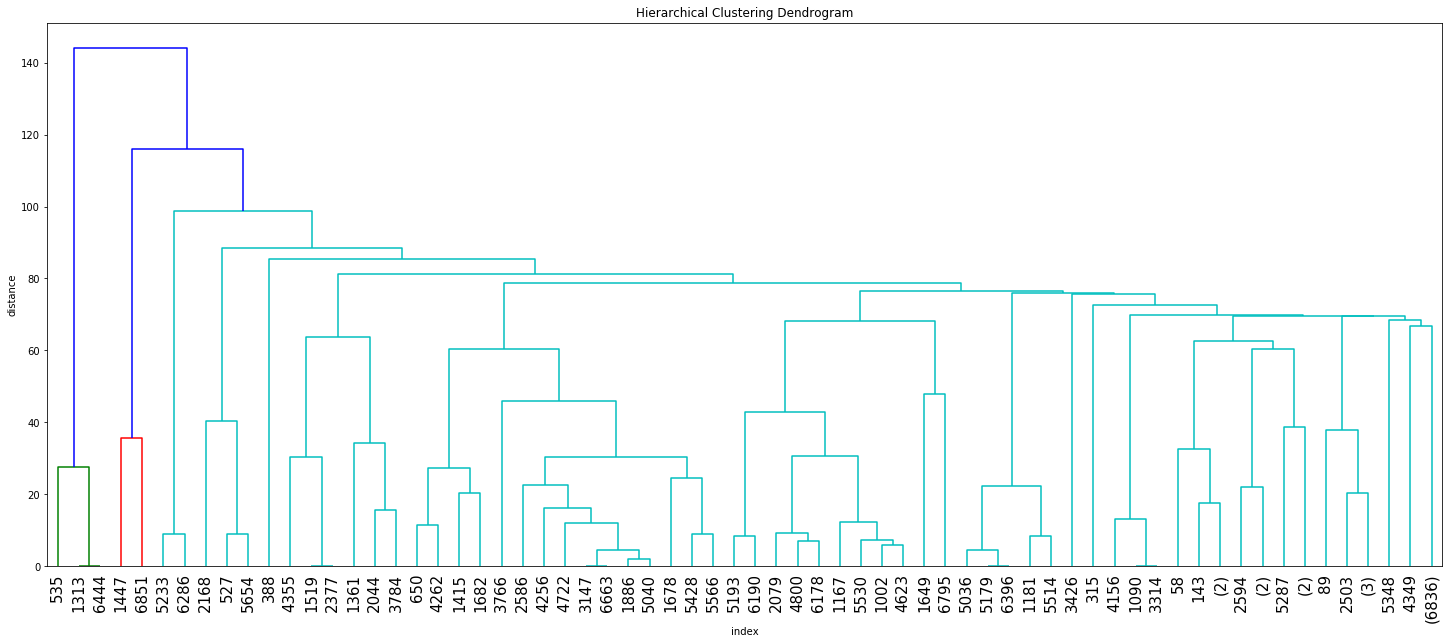

In [41]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode = 'level',
    p = 15,
    leaf_font_size=15.,  # font size for the x axis labels
)
plt.show()

In [43]:
U, s, Vt = la.svd(tfidf_m, full_matrices = False)

with open("mystery.txt") as f:
    newtext = f.read()
    
idf_df = idf(docs)


In [55]:
newtext_words = newtext.strip().lower().translate(str.maketrans('-', ' ', string.punctuation)).split()
terms = [term for term in idf_df.index]

tf_new = np.zeros((len(terms)), dtype = 'int')
for i, term in enumerate(terms):
    tf_new[i] = newtext_words.count(term)

tfidf_new = np.array(idf_df) * tf_new.reshape((-1,1))

911.0632976017828

In [56]:
tfidf_new.T @ U[:, :k] @ la.inv(np.diag(s[:k]))

array([[-0.015 ,  0.1   , -0.0283,  0.0537, -0.0753, -0.0065, -0.0563,
        -0.008 , -0.0868,  0.0037, -0.0099,  0.0076, -0.0288, -0.003 ,
        -0.0853, -0.0189, -0.0037,  0.0037,  0.0616, -0.0115,  0.012 ,
        -0.0014, -0.004 ,  0.0231,  0.0218,  0.004 ,  0.0341, -0.0157,
         0.0193,  0.0056,  0.0114,  0.0019, -0.0054,  0.003 ,  0.0052,
         0.0264,  0.018 ,  0.0245,  0.0029,  0.038 ,  0.0222,  0.0098,
        -0.0031, -0.0052, -0.0357, -0.0177,  0.0097, -0.0079,  0.0014,
        -0.0035,  0.0256,  0.0401, -0.0045,  0.0162, -0.0205, -0.0052,
        -0.0032,  0.0025,  0.0048, -0.0143,  0.027 , -0.0498, -0.0128,
         0.027 ,  0.0004, -0.0196,  0.0147, -0.0033,  0.0122, -0.0071,
         0.0048, -0.0108, -0.028 ,  0.0441,  0.0087,  0.0188, -0.0062,
        -0.0102, -0.0031, -0.0185, -0.0061,  0.01  ,  0.0307, -0.0023,
        -0.0493,  0.0047, -0.0073, -0.0031, -0.0583, -0.0406,  0.015 ,
        -0.0092, -0.022 , -0.0022, -0.0061, -0.0188,  0.0298, -0.0766,
      

**Notes on the Pubmed articles**

These were downloaded with the following script.

```python
from Bio import Entrez, Medline
Entrez.email = "YOUR EMAIL HERE"
import cPickle

try:
    docs = cPickle.load(open('pubmed.pic'))
except Exception, e:
    print e

    docs = {}
    for term in ['plasmodium', 'diabetes', 'asthma', 'cytometry']:
        handle = Entrez.esearch(db="pubmed", term=term, retmax=50)
        result = Entrez.read(handle)
        handle.close()
        idlist = result["IdList"]
        handle2 = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
        result2 = Medline.parse(handle2)
        for record in result2:
            title = record.get("TI", None)
            abstract = record.get("AB", None)
            if title is None or abstract is None:
                continue
            docs[title] = '\n'.join([title, abstract])
            print title
        handle2.close()
    cPickle.dump(docs, open('pubmed.pic', 'w'))
docs.values()
```